<center><h1>Modeles de prediction d'energies



la prévision de la demande  d'electricite est essentielle poour une bonne planification d'un systeme electrique . Une bonne planificatin du systéme electrique serai d'assurer une gestion optimale d'energie et un approvisonnement sur en electricité .Dans cette perspective  notre objectif consiste a faire des prédictions sur le comportement futur de la demande d'electricite afin d'adopter la meilleeures stratégie d'invesstissment et déviter le gaspillage des ressources liés à la La surestimation de la demande d'électricité mais aussi sousestimation .ainsi nous allons utiliser certaines  méthodes de resaux de neurones  énumérées ci dessous 

* Préparer des données de séries temporelles pour l'entraînement d'un modèle de prévision par réseau neuronal convolutif (CNN)
* le  modèle LSTM avec les reseaux de neurones dans Tensorflow pour prédire la prochaine étape à venir
* le modèle CNN dans Tensorflow pour prédire la prochaine étape à venir
* le  modèle GRU avec les reseaux de neurones dans Tensorflow pour prédire la prochaine étape à venir
* Activer l'arrêt précoce pour réduire la probabilité d'un ajustement excessif du modèle
* Evaluer le modèle sur un ensemble de données de validation et de test.


### Données

Les données de ce fichier sont issues du concours de prévision GEFCom20141. Il s'agit de 3 années de valeurs horaires de charge électrique et de température entre 2012 et 2014. La tâche consiste à prévoir les valeurs futures de la charge électrique. Dans cet exemple, nous montrons comment prévoir un pas de temps à l'avance, en utilisant uniquement les données historiques de charge.

<b>ÉTAPE 1 : LIRE ET EXPLORER LES DONNEES</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<b><center><U>Importation des données avec pandas</U></b>

In [2]:
df = pd.read_csv('energy.csv')
df.head()


,timestamp,load,temp
0,2012-01-01 00:00:00,2698.0,32.000000
1,2012-01-01 01:00:00,2558.0,32.666667
2,2012-01-01 02:00:00,2444.0,30.000000
3,2012-01-01 03:00:00,2402.0,31.000000
4,2012-01-01 04:00:00,2403.0,32.000000


<b><center><U>Indexation des données</U></b>

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace = True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2012-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   load    26304 non-null  float64
 1   temp    26304 non-null  float64
dtypes: float64(2)
memory usage: 616.5 KB


In [5]:
df.isnull().sum().sort_values(ascending=False)

load    0
temp    0
dtype: int64

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
load,26304.0,3303.769199,564.579253,1979.000000,2867.000000,3364.000000,3690.000000,5224.0
temp,26304.0,47.765638,19.338142,-13.666667,32.666667,48.333333,63.666667,95.0


* Le data describe nous donne la repartition des variables dans le temps. On a une taille de la base qui est de 26304,la consommation maximale d'energie est 5224 et la minimale est a 1979.

<b>ÉTAPE 2 : PRETAITEMENT DES DONNEES</b>

### Etude de la corrélation des variables

In [7]:
df['load'].corr(df['temp'])

0.07264414094926609

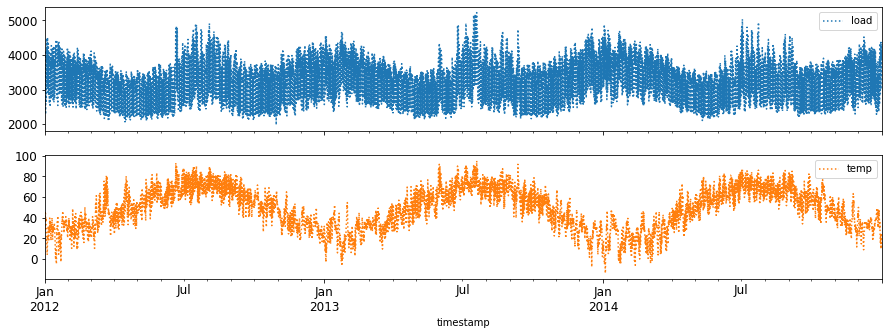

In [8]:
df.plot(y=['load','temp'],subplots=True,figsize=(15,5), fontsize=12,ls=':')
plt.show()

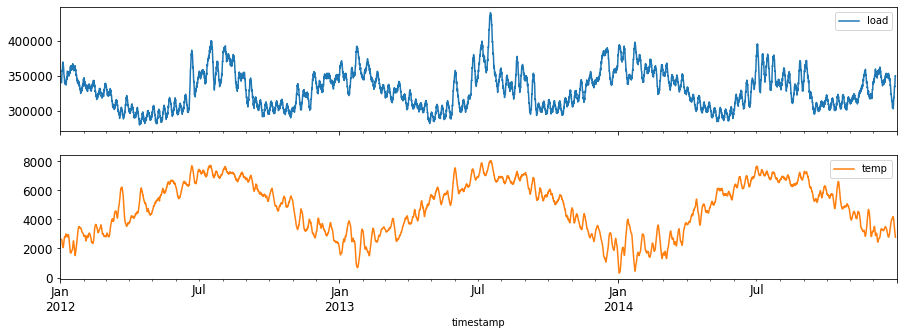

In [9]:
df.rolling(100,center=True).sum().plot(y=['load','temp'],subplots=True,figsize=(15,5), fontsize=12)
plt.show()

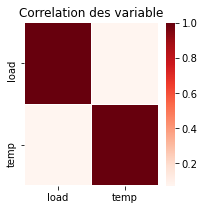

In [10]:
import seaborn as sns
plt.figure(figsize = (3,3))
plt.title('Correlation des variable')
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

* La correlation de la variable 'temp' et de 'load' est tres faible,elle est de l'ordre de 0.07. On en deduit que la consommation d'energie ne depend pas du temps. Comme notre objectif est de predire la consommation,dans ce qui reste nous allons travailler avec une seule variable 'load'

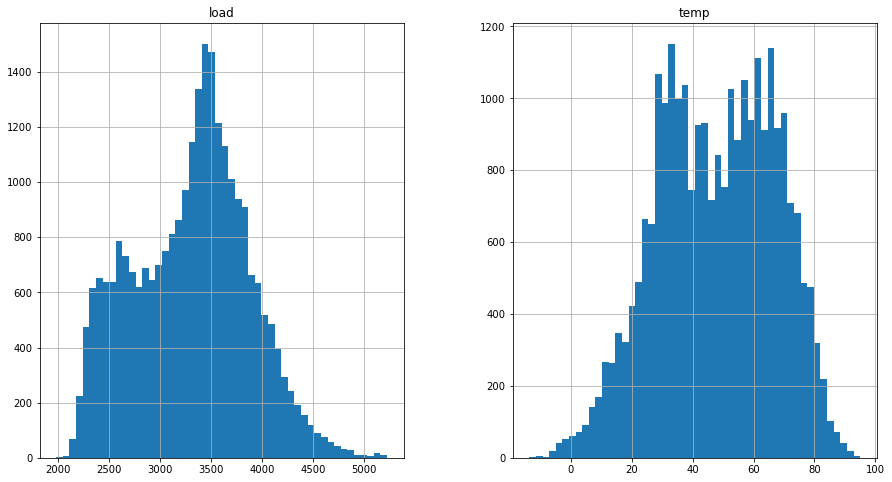

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(15,8))
plt.show()

* Nous essayons de voir la distribution

<AxesSubplot:xlabel='time'>

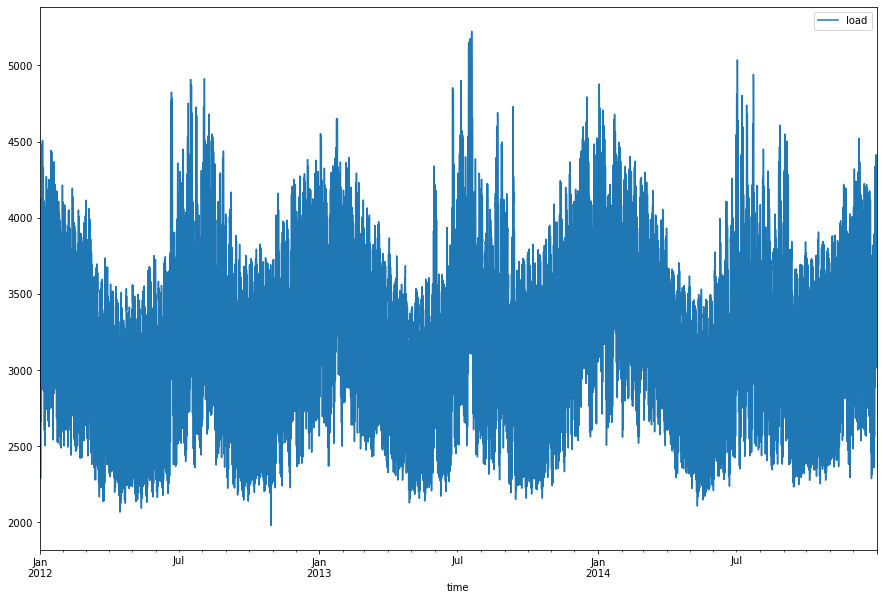

In [12]:
data=pd.read_csv('energy.csv',sep =',')
data['time']=pd.to_datetime(data['timestamp'])
energy=data.loc[:, ['load']]
energy=energy.set_index(data.time)
energy['load']=pd.to_numeric(energy['load'],downcast='float',errors='raise')
energy.plot(figsize=(15,10),fontsize=(10))
#energy.drop(['timestamp','temp','time'],1,inplace=True)

#### scinder les donnees en semaines

<AxesSubplot:xlabel='time'>

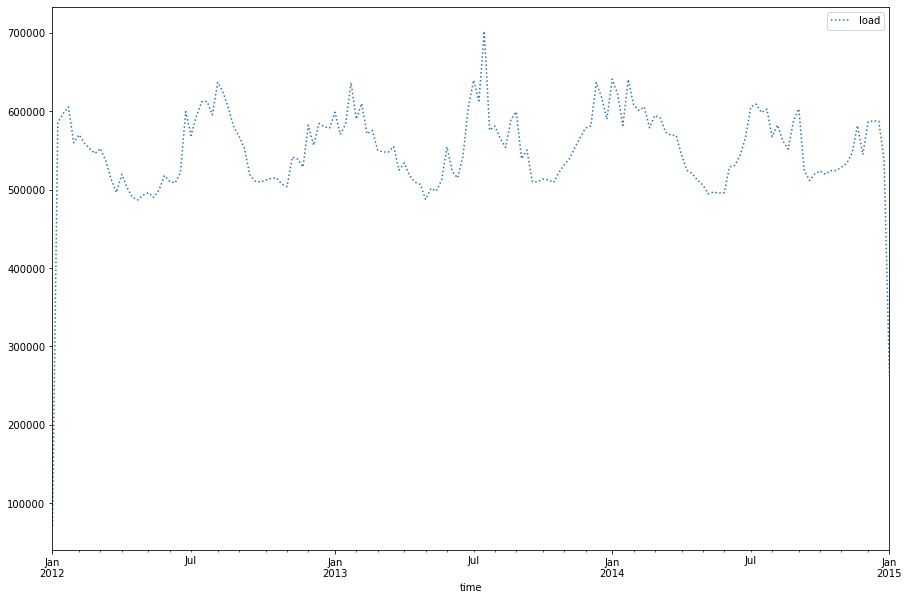

In [13]:
weekly=energy.resample('W').sum()
weekly.plot(figsize=(15,10),fontsize=(10),style=[':','--','-'])

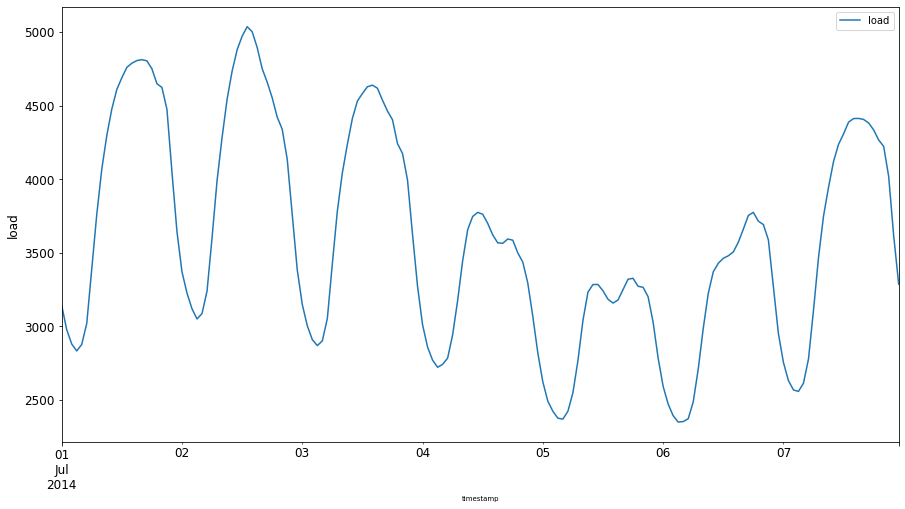

In [14]:
energy['2014-07-01':'2014-07-07'].plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=7)
plt.ylabel('load', fontsize=12)
plt.show()


* On voit avec que la consommation journaliere n'est pas le meme durant la semaine.Dans cet exemple, on voit une consommation maximale au deuxieme et une consommation mininimale au cinquieme jour.


## Creation des ensemble d'entrainement, ensemble de validation et ensemble  test
Nous séparons notre ensemble de données en ensembles d'entrainement, de validation et de test. L'ensemble de validation est utilisé pour évaluer le modèle après chaque époque de formation et s'assurer que le modèle ne surajuste pas les données de formation. 

In [15]:
valid_df = '2014-09-01 00:00:00'
test_df = '2014-11-01 00:00:00'

Nous allouerons la période du 1er novembre 2014 au 31 décembre 2014 à l'ensemble de test. La période du 1er septembre 2014 au 31 octobre est allouée à l'ensemble de validation. Toutes les autres périodes sont disponibles pour l'ensemble d'entraînement.

## Preparation des donnees d'entrainement

* Dans cette partie nous utilisons un time steep egale a $10$

In [16]:
T = 10

### 1. Creer un esemble d'entrainement pour notre modele
* Nous utilisons l'ensemble des donnees allant du 1er janvier 2012 au 1er novembre 2014 
* Nous utilisons la fonction "MinMaxScaler" pour mettre les donnees dans la plage (0,1)

In [17]:
train = df.copy()[df.index < valid_df][['load']]
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train['load'] = sc.fit_transform(train)
train.head(10)

,load
timestamp,
2012-01-01 00:00:00,0.221572
2012-01-01 01:00:00,0.178428
2012-01-01 02:00:00,0.143297
2012-01-01 03:00:00,0.130354
2012-01-01 04:00:00,0.130663
2012-01-01 05:00:00,0.146071
2012-01-01 06:00:00,0.179045
2012-01-01 07:00:00,0.228043
2012-01-01 08:00:00,0.288752


### 3. Shift les valeurs des times serie pour creer des dataFrame

In [18]:
trainSh = train.copy()
trainSh['y'] = trainSh['load'].shift(-1, freq='H')
for t in range(1, T+1):
    trainSh['load_t-'+str(T-t)] = trainSh['load'].shift(T-t, freq='H')
trainSh = trainSh.rename(columns={'load':'load_original'})
trainSh = trainSh.dropna(how='any')
trainSh.head(20)

,load_original,y,load_t-9,load_t-8,load_t-7,load_t-6,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,,,,,,
2012-01-01 09:00:00,0.346995,0.368259,0.221572,0.178428,0.143297,0.130354,0.130663,0.146071,0.179045,0.228043,0.288752,0.346995
2012-01-01 10:00:00,0.368259,0.370108,0.178428,0.143297,0.130354,0.130663,0.146071,0.179045,0.228043,0.288752,0.346995,0.368259
2012-01-01 11:00:00,0.370108,0.371341,0.143297,0.130354,0.130663,0.146071,0.179045,0.228043,0.288752,0.346995,0.368259,0.370108
2012-01-01 12:00:00,0.371341,0.359938,0.130354,0.130663,0.146071,0.179045,0.228043,0.288752,0.346995,0.368259,0.370108,0.371341
2012-01-01 13:00:00,0.359938,0.352234,0.130663,0.146071,0.179045,0.228043,0.288752,0.346995,0.368259,0.370108,0.371341,0.359938
2012-01-01 14:00:00,0.352234,0.356857,0.146071,0.179045,0.228043,0.288752,0.346995,0.368259,0.370108,0.371341,0.359938,0.352234
2012-01-01 15:00:00,0.356857,0.464407,0.179045,0.228043,0.288752,0.346995,0.368259,0.370108,0.371341,0.359938,0.352234,0.356857
2012-01-01 16:00:00,0.464407,0.535593,0.228043,0.288752,0.346995,0.368259,0.370108,0.371341,0.359938,0.352234,0.356857,0.464407
2012-01-01 17:00:00,0.535593,0.517720,0.288752,0.346995,0.368259,0.370108,0.371341,0.359938,0.352234,0.356857,0.464407,0.535593


### 4. Transformer la dimension de nos donnees


In [19]:
y_train = trainSh[['y']]
X_train = trainSh[['load_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_train = X_train[... , np.newaxis]
y_train.shape

(23366, 1)

In [20]:
X_train.shape

(23366, 10, 1)

In [21]:
X_train[:1]

array([[[0.22157165],
        [0.17842835],
        [0.14329738],
        [0.13035439],
        [0.13066256],
        [0.14607088],
        [0.17904468],
        [0.22804314],
        [0.28875193],
        [0.34699538]]])

## Preparation de l'ensemble de validation


In [22]:
import datetime as dt

dd = dt.datetime.strptime(valid_df, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=dd) & (df.index < test_df)][['load']]
valid['load'] = sc.transform(valid)
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    valid_shifted['load_t-'+str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')
valid_shifted = valid_shifted.dropna(how='any')
y_valid = valid_shifted['y+1'].to_numpy()
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_valid = X_valid[..., np.newaxis]
valid.head()

,load
timestamp,
2014-08-31 15:00:00,0.565177
2014-08-31 16:00:00,0.579353
2014-08-31 17:00:00,0.603082
2014-08-31 18:00:00,0.609553
2014-08-31 19:00:00,0.613251


In [23]:
y_valid.shape

(1463,)

In [24]:
X_valid.shape

(1463, 10, 1)

## Creation de donnees test pour evaluer les modeles

In [25]:
test = df.copy()[test_df:][['load']]
test['load'] = sc.transform(test)
test.head()

,load
timestamp,
2014-11-01 00:00:00,0.164869
2014-11-01 01:00:00,0.140216
2014-11-01 02:00:00,0.126656
2014-11-01 03:00:00,0.124191
2014-11-01 04:00:00,0.135593


* On met l'ensemble test dans une plage 0 et 1, en utlisant la meme configuration faite sur les donnees d'entrainement et validation

In [26]:
test_sh = test.copy()
test_sh['y_t+1'] = test_sh['load'].shift(-1, freq='H')
for t in range(1, T+1):
    test_sh['load_t-'+str(T-t)] = test_sh['load'].shift(T-t, freq='H')
test_sh = test_sh.dropna(how='any')
y_test = test_sh['y_t+1'].to_numpy()
X_test = test_sh[['load_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_test = X_test[... , np.newaxis]

# LSTM

In [69]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


# Initialisation de notre RNN
regressor = Sequential()

# Ajout de la premier couche et des Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Ajout de la deuxieme couche LSTM et des Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))


# Ajout de la troisieme couche LSTM et des Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))


# Ajout de la quatrieme couche LSTM et des Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Ajout de la couche de sortie
regressor.add(Dense(units = 1))

# Compilation
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


# Fitting the RNN to the Training set
history = regressor.fit(X_train, y_train, epochs = 100,
              validation_data=(X_valid, y_valid),
              batch_size = 32)

Epoch 1/100
731/731 [==============================] - 16s 21ms/step - loss: 0.0203 - val_loss: 0.0040
Epoch 2/100
731/731 [==============================] - 13s 18ms/step - loss: 0.0041 - val_loss: 0.0010
Epoch 3/100
731/731 [==============================] - 14s 19ms/step - loss: 0.0024 - val_loss: 6.9078e-04
Epoch 4/100
731/731 [==============================] - 13s 18ms/step - loss: 0.0018 - val_loss: 7.9176e-04
Epoch 5/100
731/731 [==============================] - 13s 18ms/step - loss: 0.0015 - val_loss: 4.5712e-04
Epoch 6/100
731/731 [==============================] - 13s 18ms/step - loss: 0.0013 - val_loss: 4.5654e-04
Epoch 7/100
731/731 [==============================] - 13s 18ms/step - loss: 0.0011 - val_loss: 3.9185e-04
Epoch 8/100
731/731 [==============================] - 14s 19ms/step - loss: 0.0010 - val_loss: 3.6337e-04
Epoch 9/100
731/731 [==============================] - 14s 19ms/step - loss: 9.9554e-04 - val_loss: 6.0519e-04
Epoch 10/100
731/731 [===================

In [70]:
predictions_LSTM = regressor.predict(X_test)


* On fait une prediction sur les donnees test

In [71]:
eval_LSTM = pd.DataFrame(predictions_LSTM, columns=['t+'+str(t) for t in range(1, 2)])
eval_LSTM['timestamp'] = test_sh.index
eval_LSTM = pd.melt(eval_LSTM, id_vars='timestamp', value_name='predictions_LSTM', var_name='h')
eval_LSTM['actuelle'] = np.transpose(y_test).ravel()
eval_LSTM[['predictions_LSTM', 'actuelle']] = sc.inverse_transform(eval_LSTM[['predictions_LSTM', 'actuelle']])
eval_LSTM.head()

,timestamp,h,predictions_LSTM,actuelle
0,2014-11-01 09:00:00,t+1,3421.825888,3436.0
1,2014-11-01 10:00:00,t+1,3439.563104,3464.0
2,2014-11-01 11:00:00,t+1,3422.633114,3439.0
3,2014-11-01 12:00:00,t+1,3367.809528,3407.0
4,2014-11-01 13:00:00,t+1,3354.031850,3389.0


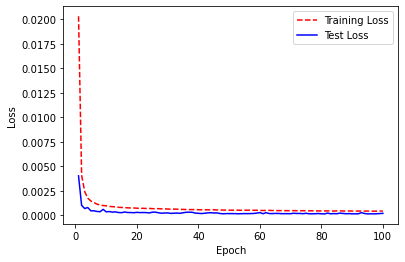

In [74]:

training_loss = history.history['loss']
test_loss = history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

# Visualisation de loss hystiry
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

La courbe d'erreur sur les donnees test et la courbe d'erreur des donnees train est proche donc on peut dire que le modele fonctionne bien. Celle du train est en dessus de celle du test, on peut dire qu'il ny a pas de surapprentissage.

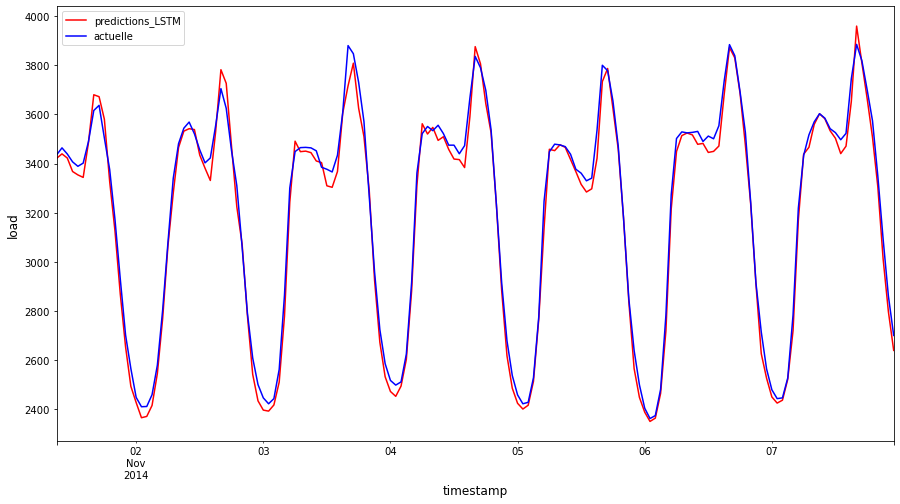

In [75]:
eval_LSTM[eval_LSTM.timestamp<'2014-11-08'].plot(x='timestamp', y=['predictions_LSTM', 'actuelle'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [ ]:
On voit que les donnees predites sont presques egales aux reelles a des erreurs pres. En effe, on note un leger decalage.

## Convolutional Neural Network


In [86]:
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [87]:
model_CNN = Sequential()
model_CNN.add(Conv1D(5, kernel_size=2, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(T, 1)))
model_CNN.add(Conv1D(5, kernel_size=2, padding='causal', strides=1, activation='relu', dilation_rate=2))
model_CNN.add(Conv1D(5, kernel_size=2, padding='causal', strides=1, activation='relu', dilation_rate=4))
model_CNN.add(Flatten())
model_CNN.add(Dense(1, activation='linear'))

In [88]:
model_CNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 10, 5)             15        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


In [89]:
model_CNN.compile(optimizer='Adam', loss='mse')

# Early stopping Method

In [90]:
stop_CNN = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [91]:
best_val_CNN = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)


In [92]:
Resul_CNN = model_CNN.fit(X_train,
          y_train,
          batch_size=32,
          epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=[stop_CNN, best_val_CNN],
          verbose=1)

Epoch 1/100
731/731 [==============================] - 2s 3ms/step - loss: 0.0342 - val_loss: 0.0079
Epoch 2/100
731/731 [==============================] - 2s 3ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 3/100
731/731 [==============================] - 2s 2ms/step - loss: 0.0010 - val_loss: 7.4594e-04
Epoch 4/100
731/731 [==============================] - 2s 3ms/step - loss: 7.6259e-04 - val_loss: 6.3414e-04
Epoch 5/100
731/731 [==============================] - 2s 3ms/step - loss: 6.7383e-04 - val_loss: 5.9503e-04
Epoch 6/100
731/731 [==============================] - 2s 2ms/step - loss: 6.1168e-04 - val_loss: 4.9834e-04
Epoch 7/100
731/731 [==============================] - 2s 2ms/step - loss: 5.7187e-04 - val_loss: 4.8627e-04
Epoch 8/100
731/731 [==============================] - 2s 2ms/step - loss: 5.4666e-04 - val_loss: 4.4034e-04
Epoch 9/100
731/731 [==============================] - 2s 2ms/step - loss: 5.2328e-04 - val_loss: 4.7359e-04
Epoch 10/100
731/731 [=================

In [93]:
best_epoch_CNN = np.argmin(np.array(Resul_CNN.history['val_loss']))+1
model_CNN.load_weights("model_{:02d}.h5".format(best_epoch_CNN))

In [94]:
best_epoch_CNN

19

le meilleur epoch est a 19

* La courbe d'eureur sur les donnees d'entrainement et sur les donnees test

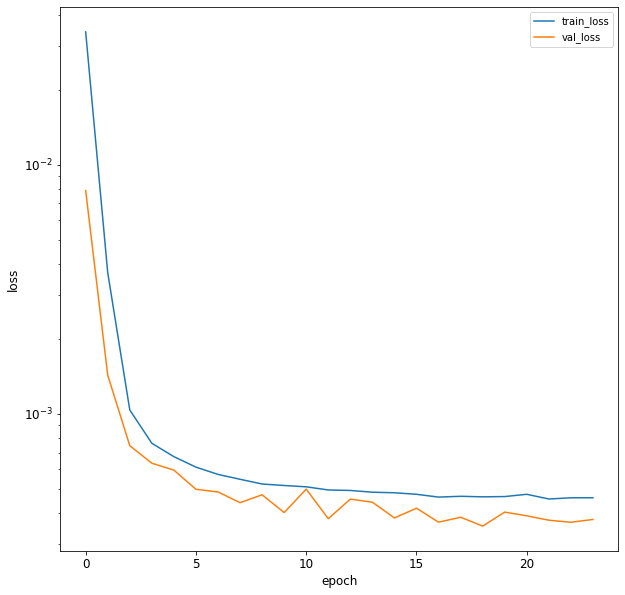

In [95]:
plot_CNN = pd.DataFrame.from_dict({'train_loss':Resul_CNN.history['loss'], 'val_loss':Resul_CNN.history['val_loss']})
plot_CNN.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

On voit qu'ici les deux loss (train,test) sont proches aussi donc on peut dire que le modele CNN est bon.

## Evaluons le model


* Prediction sur les donnees test

In [35]:
predictions_CNN = model_CNN.predict(X_test)


* Comparer les valeurs predictes aux valeur actuelles

In [36]:
eval_CNN = pd.DataFrame(predictions_CNN, columns=['t+'+str(t) for t in range(1, 2)])
eval_CNN['timestamp'] = test_sh.index
eval_CNN = pd.melt(eval_CNN, id_vars='timestamp', value_name='predictions_CNN', var_name='h')
eval_CNN['actuelle'] = np.transpose(y_test).ravel()
eval_CNN[['predictions_CNN', 'actuelle']] = sc.inverse_transform(eval_CNN[['predictions_CNN', 'actuelle']])
eval_CNN.head()

,timestamp,h,predictions_CNN,actuelle
0,2014-11-03 11:00:00,t+1,3395.454824,3385.0
1,2014-11-03 12:00:00,t+1,3313.821408,3377.0
2,2014-11-03 13:00:00,t+1,3349.876574,3366.0
3,2014-11-03 14:00:00,t+1,3391.109032,3434.0
4,2014-11-03 15:00:00,t+1,3592.756485,3609.0


* courbe sur les valeurs predite par le model et les valeurs reels

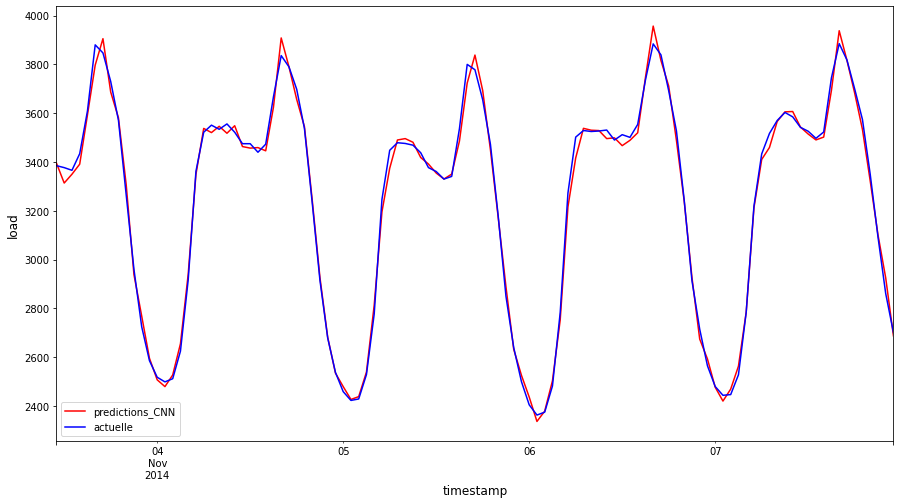

In [37]:
eval_CNN[eval_CNN.timestamp<'2014-11-08'].plot(x='timestamp', y=['predictions_CNN', 'actuelle'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

On voit que la prevision est bonne,les donnees predites sont presques egales aux reelles a des erreurs pres. En effet, on note un leger decalage.

# Le model RNN GRU

In [27]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

In [41]:
model_RNN_GRU= Sequential()
model_RNN_GRU.add(GRU(5, input_shape=(T, 1)))
model_RNN_GRU.add(Dense(1))

In [42]:
model_RNN_GRU.compile(optimizer='RMSprop', loss='mse')

In [43]:
#model_RNN.summary()

In [44]:
stop_GRU = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [45]:
history_GRU = model_RNN_GRU.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[stop_GRU],
                    verbose=1)

Epoch 1/100
731/731 [==============================] - 3s 5ms/step - loss: 0.0124 - val_loss: 0.0014
Epoch 2/100
731/731 [==============================] - 3s 4ms/step - loss: 0.0010 - val_loss: 8.4334e-04
Epoch 3/100
731/731 [==============================] - 3s 4ms/step - loss: 6.4491e-04 - val_loss: 5.2337e-04
Epoch 4/100
731/731 [==============================] - 3s 4ms/step - loss: 5.6117e-04 - val_loss: 6.4187e-04
Epoch 5/100
731/731 [==============================] - 3s 4ms/step - loss: 5.5045e-04 - val_loss: 7.6403e-04
Epoch 6/100
731/731 [==============================] - 3s 4ms/step - loss: 5.4666e-04 - val_loss: 9.6031e-04
Epoch 7/100
731/731 [==============================] - 3s 4ms/step - loss: 5.4328e-04 - val_loss: 5.0131e-04
Epoch 8/100
731/731 [==============================] - 3s 4ms/step - loss: 5.3769e-04 - val_loss: 5.0086e-04
Epoch 9/100
731/731 [==============================] - 3s 4ms/step - loss: 5.3397e-04 - val_loss: 5.1921e-04
Epoch 10/100
731/731 [=========

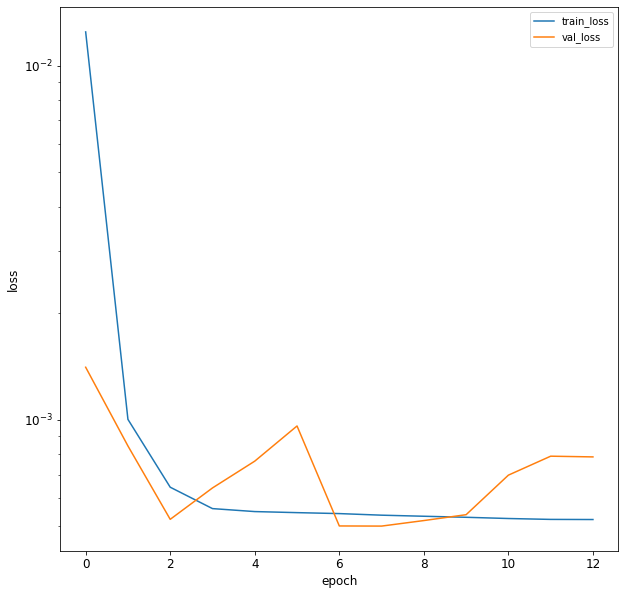

In [46]:
plot_GRU = pd.DataFrame.from_dict({'train_loss':history_GRU.history['loss'], 'val_loss':history_GRU.history['val_loss']})
plot_GRU.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

La visualisation loss train/loss test nous montre que le modele GRU est moins bon que les autres dans ce cas et on peut songer a des previsions pour voir.

## Evaluation du model

In [49]:
predictions_RNN_GRU = model_RNN_GRU.predict(X_test)
predictions_RNN_GRU

array([[0.47125345],
       [0.46868032],
       [0.47542083],
       ...,
       [0.54743886],
       [0.47932258],
       [0.43602887]], dtype=float32)

In [50]:
eval_GRU = pd.DataFrame(predictions_RNN_GRU, columns=['t+'+str(t) for t in range(1, 2)])
eval_GRU['timestamp'] = test_sh.index
eval_GRU = pd.melt(eval_GRU, id_vars='timestamp', value_name='predictions_RNN_GRU', var_name='h')
eval_GRU['actuelles'] = np.transpose(y_test).ravel()
eval_GRU[['predictions_RNN_GRU', 'actuelles']] = sc.inverse_transform(eval_GRU[['predictions_RNN_GRU', 'actuelles']])
eval_GRU.head()

,timestamp,h,predictions_RNN_GRU,actuelles
0,2014-11-01 09:00:00,t+1,3508.217460,3436.0
1,2014-11-01 10:00:00,t+1,3499.867645,3464.0
2,2014-11-01 11:00:00,t+1,3521.740602,3439.0
3,2014-11-01 12:00:00,t+1,3445.323161,3407.0
4,2014-11-01 13:00:00,t+1,3437.688602,3389.0


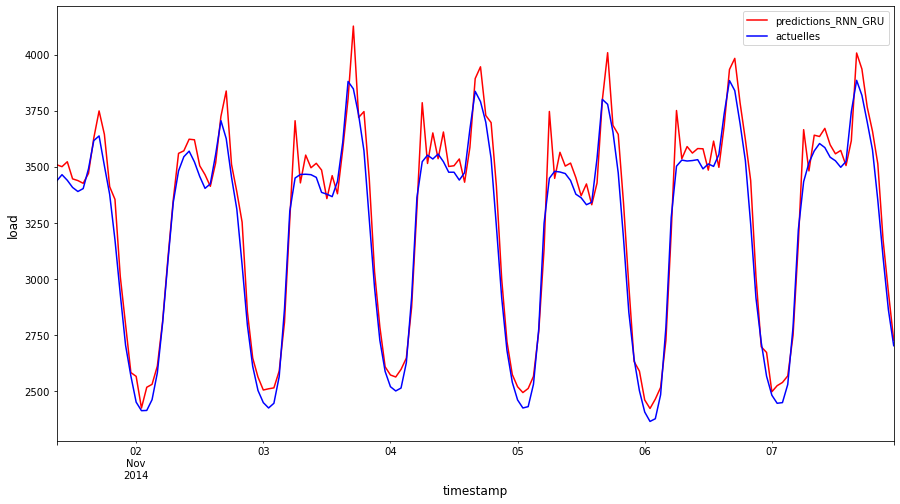

In [52]:
eval_GRU[eval_GRU.timestamp<'2014-11-08'].plot(x='timestamp', y=['predictions_RNN_GRU', 'actuelles'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

Ayant utilise LSRTM,GRU,nous avons vu que les modeles LSTM et CNN s'adaptent mieux aux donnees que le GRU qui predit moins efficacement. 

Pour la gestion de la consommation d'energie,nous avons eu recours au deep learning pour pouvoir predire les valeurs a un instant donnee T. Au besoin de preparer la consommation ulterieure, on est capable de faire un debit approche pour la satisfaction et la couverture de l'energie.On est capable de faire un debit approche pour la satisfaction et la couverture de l'energie.